In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

import random

In [2]:
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator

In [3]:
for dirName,_,fileNames in os.walk('Images/'):
    for files in fileNames:
        print(os.path.join(dirName,files))

Images/daisy\100080576_f52e8ee070_n.jpg
Images/daisy\10140303196_b88d3d6cec.jpg
Images/daisy\10172379554_b296050f82_n.jpg
Images/daisy\10172567486_2748826a8b.jpg
Images/daisy\10172636503_21bededa75_n.jpg
Images/daisy\102841525_bd6628ae3c.jpg
Images/daisy\10300722094_28fa978807_n.jpg
Images/daisy\1031799732_e7f4008c03.jpg
Images/daisy\10391248763_1d16681106_n.jpg
Images/daisy\10437754174_22ec990b77_m.jpg
Images/daisy\10437770546_8bb6f7bdd3_m.jpg
Images/daisy\10437929963_bc13eebe0c.jpg
Images/daisy\10466290366_cc72e33532.jpg
Images/daisy\10466558316_a7198b87e2.jpg
Images/daisy\10555749515_13a12a026e.jpg
Images/daisy\10555815624_dc211569b0.jpg
Images/daisy\10555826524_423eb8bf71_n.jpg
Images/daisy\10559679065_50d2b16f6d.jpg
Images/daisy\105806915_a9c13e2106_n.jpg
Images/daisy\10712722853_5632165b04.jpg
Images/daisy\107592979_aaa9cdfe78_m.jpg
Images/daisy\10770585085_4742b9dac3_n.jpg
Images/daisy\10841136265_af473efc60.jpg
Images/daisy\10993710036_2033222c91.jpg
Images/daisy\10993818044_4c

In [4]:
def show_image(dir):
    plt.figure(figsize=(12,7))
    for i in range(10):
        plt.subplot(2,5,i+1)
        img = random.choice(os.listdir(dir))
        img = load_img(os.path.join(dir,img))
        plt.subplots_adjust(hspace=0.2)
        x =dir.split("/")[-1]
        if x == "daisy":
            plt.suptitle("Daisy Images",fontsize=15)
        elif x == "dandelion":
            plt.suptitle("Dandelion Images",fontsize=15)
        elif x == "rose":
            plt.suptitle("Rose Images",fontsize=15)
        elif x == "sunflower":
            plt.suptitle("Sunflower Images",fontsize=15)
        elif x == "tulip":
            plt.suptitle("Tulip Images",fontsize=15)          
        plt.imshow(img)
        
        
    plt.tight_layout()

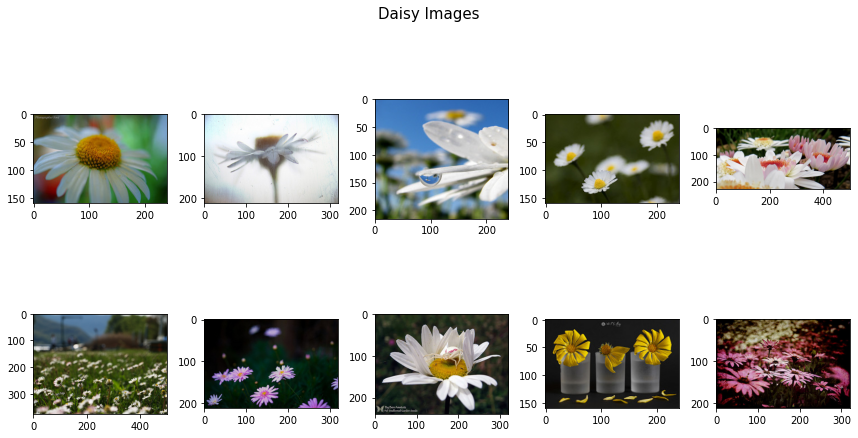

In [5]:
show_image('Images/daisy')

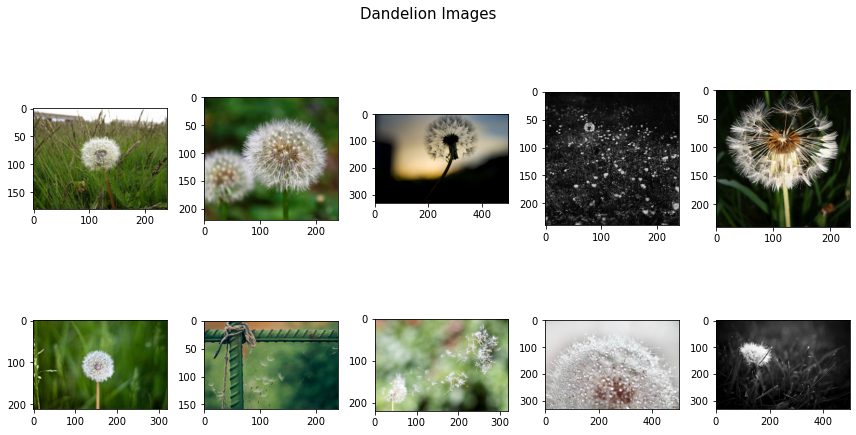

In [6]:
show_image('Images/dandelion')

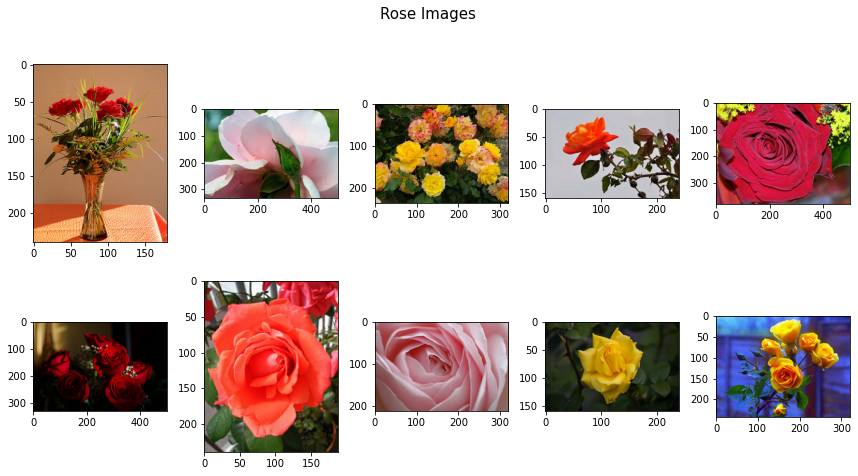

In [7]:
show_image('Images/rose')

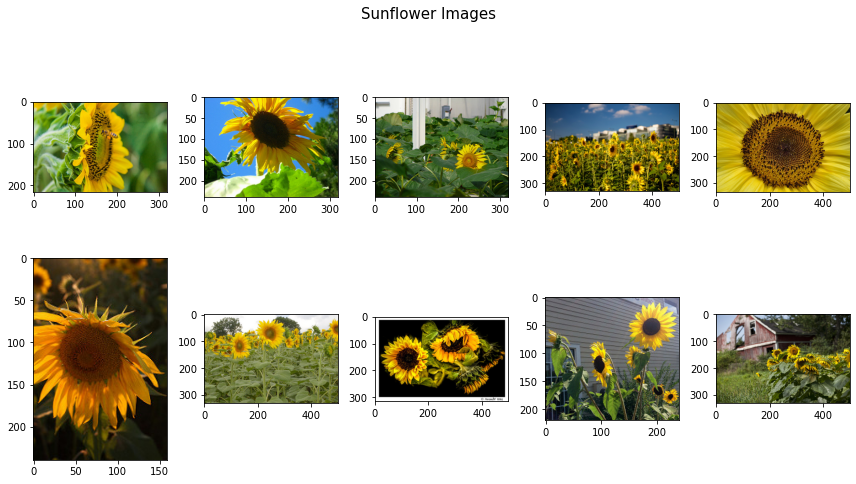

In [8]:
show_image('Images/sunflower')

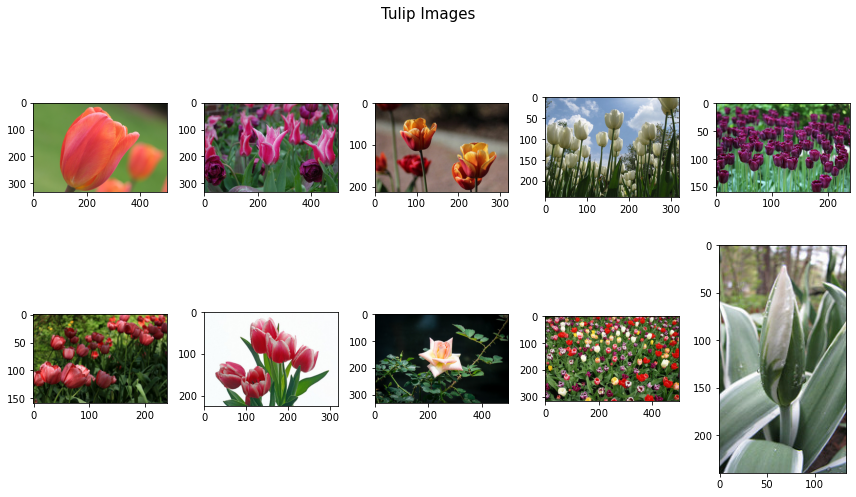

In [9]:
show_image('Images/tulip')

In [10]:
traindir='Images/'
os.listdir(traindir)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [11]:
ht = 150
wd = 150
train_datagen =  ImageDataGenerator(rescale = 1/255.0,
                                    rotation_range=45,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    validation_split=0.2,
                                    horizontal_flip=True)

train_data = train_datagen.flow_from_directory(directory = traindir,
                                               target_size=(ht,wd),
                                               class_mode = "categorical",
                                               batch_size=32,
                                               subset="training")

val_datagen = ImageDataGenerator(rescale = 1/255.0)

val_data = train_datagen.flow_from_directory(directory = traindir,
                                             target_size=(ht,wd),
                                             class_mode = "categorical",
                                             batch_size=32,
                                             subset="validation")

Found 3470 images belonging to 5 classes.
Found 863 images belonging to 5 classes.


In [12]:
print(train_data.class_indices)

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}


In [13]:
labels='\n'.join(sorted(train_data.class_indices.keys()))

with open('labels.txt','w') as f:
    f.write(labels)

In [14]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [15]:
mobileNet=MobileNetV2(weights="imagenet",include_top=False,input_shape=(ht,wd,3))

In [16]:
for l in mobileNet.layers:
    l.trainable=False

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten,Dense,Dropout,Conv2D,MaxPool2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

In [18]:
model=Sequential()
model.add(mobileNet)
model.add(Conv2D(32,3,activation='relu'))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())
model.add(Dense(5,activation="softmax"))

model.compile(optimizer=Adam(lr=0.001),loss="categorical_crossentropy",metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 3, 3, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 2,626,821
Trainable params: 368,837
Non-trainable params: 2,257,984
_________________________________________________________________


In [19]:
checkpoint = ModelCheckpoint("FlowerClassifier.h5",monitor = "val_accuracy",save_best_only = True,verbose=1)
earlystop = EarlyStopping(monitor='val_accuracy',patience=5,verbose=1)

In [20]:
batch_size = 4
history = model.fit_generator(train_data,
                              steps_per_epoch = len(train_data)// batch_size,
                              epochs=30,
                              validation_data = val_data,
                              validation_steps = len(val_data)//batch_size,
                              callbacks = [checkpoint,earlystop],
                              verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
27/27 [==============================] - ETA: 0s - loss: 1.5044 - accuracy: 0.4549
Epoch 00001: val_accuracy improved from -inf to 0.58854, saving model to FlowerClassifier.h5
27/27 [==============================] - 45s 2s/step - loss: 1.5044 - accuracy: 0.4549 - val_loss: 1.0758 - val_accuracy: 0.5885
Epoch 2/30
27/27 [==============================] - ETA: 0s - loss: 0.9371 - accuracy: 0.6435
Epoch 00002: val_accuracy improved from 0.58854 to 0.67188, saving model to FlowerClassifier.h5
27/27 [==============================] - 34s 1s/step - loss: 0.9371 - accuracy: 0.6435 - val_loss: 0.7339 - val_accuracy: 0.6719
Epoch 3/30
27/27 [==============================] - ETA: 0s - loss: 0.8338 - accuracy: 0.6817
Epoch 00003: val_accuracy improved from 0.67188 to 0.74479, saving model to FlowerClassifier.h5
27/27 [==============================] - 28s 1s/step - loss: 0.8338 - accuracy: 0.6817 - val_loss: 

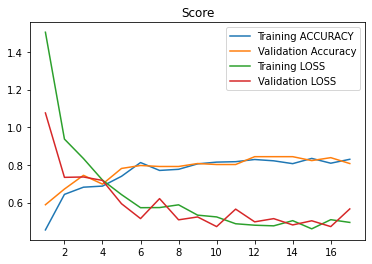

In [21]:
ACC=history.history['accuracy']
LOSS=history.history['loss']
val_ACC=history.history['val_accuracy']
val_LOSS=history.history['val_loss']
epochs=range(1,len(ACC)+1)


plt.title("Score")
plt.plot(epochs,ACC,label='Training ACCURACY')
plt.plot(epochs,val_ACC,label='Validation Accuracy')
plt.legend()

plt.plot(epochs,LOSS,label='Training LOSS')
plt.plot(epochs,val_LOSS,label='Validation LOSS')
plt.legend()



{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

In [22]:
from tensorflow.keras.preprocessing import image

In [23]:
def classifyImg(img):
    label = {0:"daisy",1:"dandelion",2:"rose",3:"sunflower",4:"tulip"} 
    image =cv2.imread(img)
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    face=image
    face = cv2.resize(face,(150,150))
    img_scaled = face/255.0
    reshape = np.reshape(img_scaled,(1,150,150,3))
    img = np.vstack([reshape])
    result = model.predict_classes(img)
    
    
    if result == 0: 
        print("Prediction : Daisy")
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        
        
    elif result == 1:
        print("Prediction : Dandelion")
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        
    elif result == 2:
        print("Prediction : Rose")
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        
    elif result == 3:
        print("Prediction : Sunflower")
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        
    elif result == 4:
        print("Prediction : Tulip")
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        
        
        
        
    
plt.show()


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Prediction : Rose


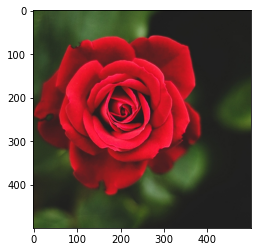

In [24]:
classifyImg('1.jpg')

Prediction : Dandelion


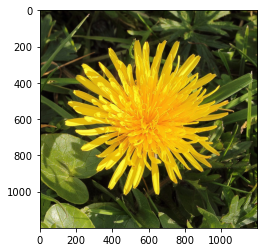

In [25]:
classifyImg('2.jpg')

Prediction : Tulip


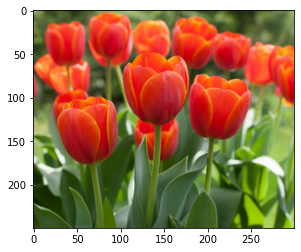

In [26]:
classifyImg('3.jpg')

Prediction : Sunflower


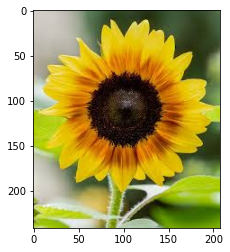

In [27]:
classifyImg('8.jfif')

Prediction : Daisy


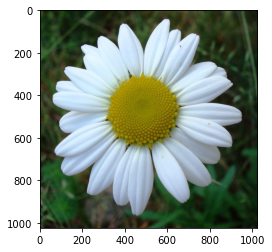

In [28]:
classifyImg('5.jpg')

In [29]:
import tensorflow as tf

model = tf.keras.models.load_model('FlowerClassifier.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("FlowerClassifier_TFL.tflite", "wb").write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\DELL\AppData\Local\Temp\tmpapf75nvy\assets


10344492